In [ ]:
# Web Scraping Indeed
import pandas as pd
import requests 
from bs4 import BeautifulSoup
import math


In [ ]:
#create function to change pages(results by 10)
def page_extraction(page) :
  # Use an f string to make the link more dynamic
  url = f'https://www.indeed.com/jobs?q=data%20engineer&l=United%20States&start={page}'
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) Gecko/20100101 Firefox/47.0 Mozilla/5.0 (Macintosh; Intel Mac OS X x.y; rv:42.0) Gecko/20100101 Firefox/42.0'}
  req = requests.get(url, headers)
  # Check status code to see if it's working
  # return req.status_code
  # page_extraction(10)
  soup = BeautifulSoup(req.content, 'html.parser')
  return(soup)


In [ ]:
# Now we can improve upon our transform function and scape specific info
# The data I am most interested in: job title, company, company rating, and salarly range (if any)

# create lists to store values in, will use to make dataframe later
title = []
comp = []
rating = []
salary = []
def transform(soup):
  main_blocks = soup.find_all('div', class_ = 'cardOutline')
  job_Num = len(main_blocks)  # this will help me later on with my try/except clause
  for item in main_blocks:
    # Title
    job_titles = item.find('a').text
    # Company
    companies = item.find('span', class_ ='companyName').text

    # Salary 
    # I am most interested in salary info, so I will only add rows that have a salary in them
    # Unfortunately this will not include Indeed's estimations, since the data is fairly different (range v 1 value, salary per hour v yearly salary)
    try:
      sal = item.find('div', class_ = 'metadata salary-snippet-container').text #[1:8] I decided to strip/filter the text later, for now I just want it as-is
      salary.append(sal)
      title.append(job_titles)
      comp.append(companies)
      # Rating
      rating.append(None) # setting default rating to null, will replace if value exists
      for link in item.find_all('span', class_ = 'ratingNumber'):
        # check for duplicates (Indeed shows a screen to the right that has the same info...resulting in extra record(s))
          if link.text not in rating:
            rating.pop() # replace None value if text exists
            rating.append(float(link.text))
    except:
      a = 1 # meaningless, but trying to do things the "right way" with try and except
  for link in item.find_all('span', class_ = 'ratingNumber'):
        # check for duplicates (Indeed shows a screen to the right that has the same info...resulting in extra record(s))
    if link.text not in rating:
      rating.pop() # replace None value if text exists
      rating.append(float(link.text))
  return 

# Call function
i = 0
while i < 400 : 
  extract = page_extraction(i)
  trans = transform(extract)
  i += 10

In [ ]:
df = pd.DataFrame({
    'title': title,
    'company': comp,
    'rating': rating,
    'salary': salary})

df.head(10)

,title,company,rating,salary
0,Sr. Data Engineer,Uplight,4.2,"$135,000 - $150,000 a year"
1,Data Engineer,Anheuser-Busch,3.7,"$94,000 - $105,750 a year"
2,Software Engineer - Data Junkie,"Chameleon Consulting Group, LLC",NaN,"$120,000 - $180,000 a year"
3,Data Engineer,California Public Employees' Retirement System...,4.6,"$5,815 - $9,408 a month"
4,Data Engineer,Dutch Bros,4.1,"$84,080 - $117,940 a year"
5,Data Engineer,Nike,4.1,"$83,000 a year"
6,Data Engineer,Nike,4.1,"$83,000 a year"
7,Associate Data Engineer -Streaming,"Amazon Web Services, Inc.",3.4,"$98,200 - $160,000 a year"
8,Associate Data Engineer,Charles Schwab,3.9,"$70,700 - $111,900 a year"
9,Data Engineer (Junior),BDSA,NaN,"$70,000 - $90,000 a year"


In [ ]:
# Ok, time to deal with salary. Looks like we have a few different types, being yearly, monthly, and hourly wages
# I don't want to spend forever on this by converting hourly and monthly wages, so I've decided just to take yearly wages
# Remove records with 'monthly salary' since there are only a couple (on average) and aren't worth the trouble to keep
bad_word1 = 'month'
row_num = -1
rows_removed = 0
for i in df['salary']:
  row_num += 1
  if (bad_word1 in i):
    # print(i)
    df = df.drop(row_num)
    rows_removed += 1
print('Number of rows removed:',str(rows_removed))

Number of rows removed: 2


In [ ]:
# There are two obvious issues remaining with our salary values
# 1. Not all are ranges, meaning some have a set salary
# 2. There are essentially two meaningful values in one column, which makes it hard to use as-is.
# So, I am going to to loop through the column and make two new columns for the upper and lower number

# First I should remove the &,-s, and ','
# as well as the words 'a' and 'year' since they all say that now
# Additional characters removed as errors occured
df['salary'] = df['salary'].str.replace('-','', regex=True)
df['salary'] = df['salary'].str.replace('$','', regex=True)
df['salary'] = df['salary'].str.replace(',','', regex=True)
df['salary'] = df['salary'].str.replace('From','', regex=True)
df['salary'] = df['salary'].str.replace('year','', regex=True)
df['salary'] = df['salary'].str.replace('Up','', regex=True)
df['salary'] = df['salary'].str.replace('to','', regex=True)
df['salary'] = df['salary'].str.replace('a','', regex=True)
df['salary'] = df['salary'].str.replace('dy','', regex=True)

#Convert hour salary to yearly salary
# create two lists that will be added to df after they are full
lower_limit = []
upper_limit = []
word_hour = 'hour'

for i in df['salary']:
  ranges = i.split()
  lower = float(ranges[0]) 
   # account for only one value
   # If it only has one numeric value, then the upper limit is the same as the lower
  try:
    upper = float(ranges[1])
  except:
    upper = lower

  if word_hour in ranges:
    lower = (lower*40*50)
    upper = (upper*40*50)
  # Add values to their respective lists
  lower_limit.append(lower)
  upper_limit.append(upper)

df.insert(loc = 4, column='lower_range', value=lower_limit)
df.insert(loc = 5, column='upper_range', value=upper_limit)
df.head(5)

,title,company,rating,salary,lower_range,upper_range
0,Sr. Data Engineer,Uplight,4.2,135000 150000,135000.0,150000.0
1,Data Engineer,Anheuser-Busch,3.7,94000 105750,94000.0,105750.0
2,Software Engineer - Data Junkie,"Chameleon Consulting Group, LLC",NaN,120000 180000,120000.0,180000.0
4,Data Engineer,Dutch Bros,4.1,84080 117940,84080.0,117940.0
5,Data Engineer,Nike,4.1,83000,83000.0,83000.0


In [ ]:
# convert all numeric columns to ints or floats
df['lower_range'] = df['lower_range'].astype(int)
df['upper_range'] = df['upper_range'].astype(int)
df['rating'] = df['rating'].astype(float)
print(df.dtypes)

title           object
company         object
rating         float64
salary          object
lower_range      int64
upper_range      int64
dtype: object


In [ ]:
# Create empty list that will store the AVERAGE value
average_list = []
for i in df.index :
  temp_ave = ((df['lower_range'].loc[i] + df['upper_range'].loc[i]) / 2).astype(int)
  average_list.append(temp_ave)

df.insert(loc = 6, column='sal_avg', value=average_list)
# now DELETE the original salary column
df = df.drop('salary', axis = 1)
df.head(10)

,title,company,rating,lower_range,upper_range,sal_avg
0,Sr. Data Engineer,Uplight,4.2,135000,150000,142500
1,Data Engineer,Anheuser-Busch,3.7,94000,105750,99875
2,Software Engineer - Data Junkie,"Chameleon Consulting Group, LLC",NaN,120000,180000,150000
4,Data Engineer,Dutch Bros,4.1,84080,117940,101010
5,Data Engineer,Nike,4.1,83000,83000,83000
6,Data Engineer,Nike,4.1,83000,83000,83000
7,Associate Data Engineer -Streaming,"Amazon Web Services, Inc.",3.4,98200,160000,129100
8,Associate Data Engineer,Charles Schwab,3.9,70700,111900,91300
9,Data Engineer (Junior),BDSA,NaN,70000,90000,80000
11,Sr. Cloud Data Engineer,Piper Companies,4.5,155000,155000,155000


Correlation = 0.12


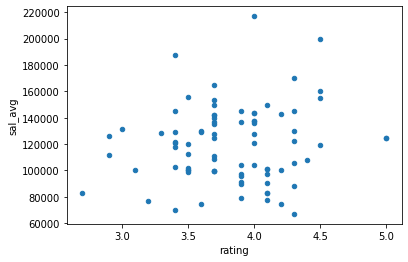

In [ ]:
# Now it's time for some analysis
# First we will create a df that only has ratings and salary ranges
clean_df = df.dropna()
corr=clean_df['rating'].corr(clean_df['sal_avg'])
corr = round(corr, 2)

# print results
print("Correlation = " + str(corr))
df.plot(kind='scatter', x = 'rating', y = 'sal_avg')

In [ ]:
# I'm considering doing some grouping from machine learning purposes, but I want to see if it will even be worth it
# Ideally, most jobs have the same, or very similar titles
# Rows left
print('Remaining rows: ', str(len(clean_df)))
# Unique titles
print('Unique titles: ', len(clean_df['title'].unique()))

clean_df['title'].value_counts()
# for group, count in clean_df['title'].value_counts().iteritems():
        
#         if count / len(clean_df) < .15:
#           df.loc[df['title'] == group, 'title'] = 'Other'


Remaining rows:  82
Unique titles:  54


Data Engineer                                               20
Senior Data Engineer                                         6
Data Security Engineer                                       2
Federal - Cloud Data Engineer (Remote Opportunity)           2
Data Engineer Analystics (Remote)                            2
Data Engineer III                                            2
Sr. Data Engineer                                            1
Data Engineer/Analytics                                      1
ETL Developer/Data Engineer                                  1
DATA ENGINEER - SQL, .NET, AWS                               1
ML Ops / Data Engineer                                       1
DATA ENGINEER-ASSOC-SR                                       1
Data Systems Engineer                                        1
Data Engineer, GovEx                                         1
Data Engineer (REMOTE-USA)                                   1
Sr. Associate Data Engineer (SQL, SSIS, Qlikview)      

There is a great deal of variability in job titles, so I will wait to pursue further analysis for this project. I think if I can use a more specific job query, I may have better luck. For now, I will wait until more jobs are available, which tend to be the end of summer through early April.